Get fields from Lumerical and save in file for later

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
from scipy.integrate import simps

lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/2020a/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

In [2]:
from scipy.constants import pi, c, epsilon_0

um = 1e-6
nm = 1e-9
pm = 1e-12
THz = 1e12

Main waveguide parameters

In [3]:
h_LN = 700*nm
h_etch = 340*nm
w_ridge = 1.85*um
h_slab = h_LN - h_etch

theta = 60
wg_length = 10*um #Useless in MODE
w_ridge_base = w_ridge + 2*h_etch/np.tan(theta*pi/180)

print('slab = %.3f um' %(h_slab))
print('width at the base = %.3f um' %(w_ridge_base))

slab = 0.000 um
width at the base = 0.000 um


Setup simulation volume and mesh sizes

In [4]:
w_slab = 20*um
h_margin = 5*um
h_substrate = 5*um
meshsize = 50*nm
finemesh = 20*nm

Materials

In [5]:
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

Wavelength range

In [6]:
wl_1 = 1*um
wl_2 = 2*um

Draw waveguide and setup solver

In [7]:
lum.draw_wg(MODE, material_thinfilm, material_substrate,
              h_LN, h_substrate, h_etch, w_ridge, w_slab, theta, wg_length)
lum.add_fine_mesh(MODE, finemesh, h_LN, w_ridge_base, x_factor=1.2, y_factor=1.5)
lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                         w_slab, wg_length, h_margin)

Solve at both frequencies and get fields

In [8]:
n1, te1 = lum.solve_mode(MODE, wl_1, nmodes=20)

In [9]:
M1 = lum.mode()
M1.get_from_lumerical(MODE, 3)
M1.N()

1.4353808923644616e-15

In [10]:
n2, te2 = lum.solve_mode(MODE, wl_2, nmodes=20)

In [11]:
M2 = lum.mode()
M2.get_from_lumerical(MODE, 1)
M2.N()

1.9105838830721865e-15

In [12]:
MODE.close()

Overlap calculation

Let's start by assuming SHG, and computing

$$

\int P\dot e^* dA

$$

In [13]:
d31 = -4.6*pm
d22 = 2.2*pm
d33 = -25*pm
d = np.array([[0, 0, 0, 0, d31, -d22], [-d22, d22, 0, d31, 0, 0], [d31, d31, d33, 0, 0, 0]])
print(d)

[[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00 -4.6e-12 -2.2e-12]
 [-2.2e-12  2.2e-12  0.0e+00 -4.6e-12  0.0e+00  0.0e+00]
 [-4.6e-12 -4.6e-12 -2.5e-11  0.0e+00  0.0e+00  0.0e+00]]


We now map the xyz Lumerical coordinates to the crystal XYZ
x -> Z
y -> X
z -> Y

In [14]:
z = M1.E.xx
x = M1.E.yy

Ew = lum.field_2D(z, x, M2.E.y, M2.E.z, M2.E.x)
E2w = lum.field_2D(z, x, M1.E.y, M1.E.z, M1.E.x)

(-9.948941464130984, 9.948941464131227, -4.944200887902331, 6.244918303832013)

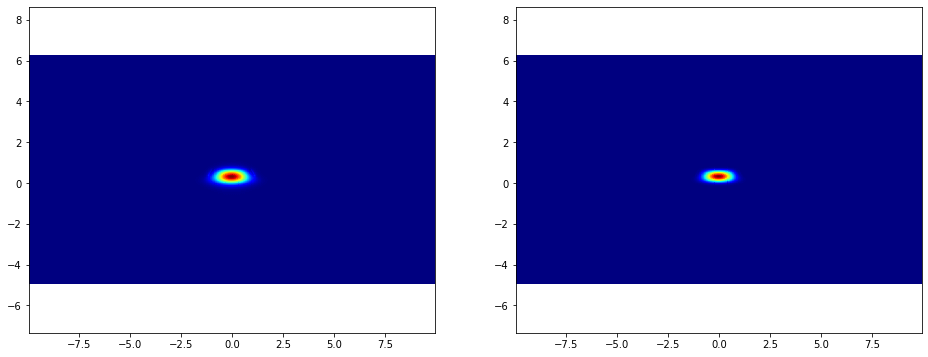

In [15]:
[Z,X] = np.meshgrid(z, x, indexing='ij')
plt.rcParams['figure.figsize'] = [16, 6]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.pcolormesh(Z*1e6, X*1e6, Ew.magsq(), cmap=cm.jet)
ax2.pcolormesh(Z*1e6, X*1e6, E2w.magsq(), cmap=cm.jet)
ax1.axis('equal')
ax2.axis('equal')

In [16]:
P2w_x = 2*epsilon_0*d[0,4]*2*Ew.z*Ew.x + 2*epsilon_0*d[0,5]*2*Ew.x*Ew.y
P2w_y = 2*epsilon_0*d[1,0]*Ew.x*Ew.x + 2*epsilon_0*d[1,1]*Ew.y*Ew.y + 2*epsilon_0*d[1,3]*2*Ew.z*Ew.y 
P2w_z = 2*epsilon_0*d[2,0]*Ew.x*Ew.x + 2*epsilon_0*d[2,1]*Ew.y*Ew.y + 2*epsilon_0*d[2,2]*Ew.z*Ew.z

P2w = lum.field_2D(z, x, P2w_x, P2w_y, P2w_z)

(-9.948941464130984, 9.948941464131227, -4.944200887902331, 6.244918303832013)

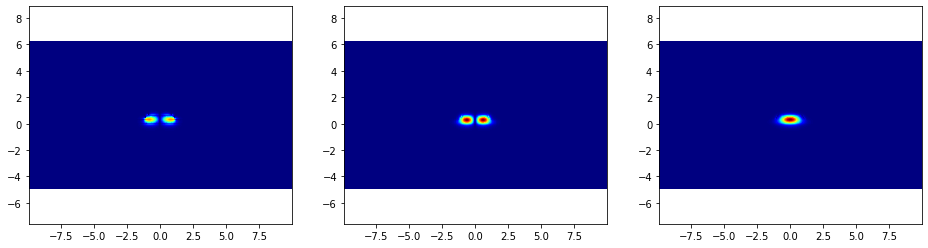

In [17]:
plt.rcParams['figure.figsize'] = [16, 4]
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pcolormesh(Z*1e6, X*1e6, np.abs(P2w.x), cmap=cm.jet)
ax2.pcolormesh(Z*1e6, X*1e6, np.abs(P2w.y), cmap=cm.jet)
ax3.pcolormesh(Z*1e6, X*1e6, np.abs(P2w.z), cmap=cm.jet)
ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')

(-9.948941464130984, 9.948941464131227, -4.944200887902331, 6.244918303832013)

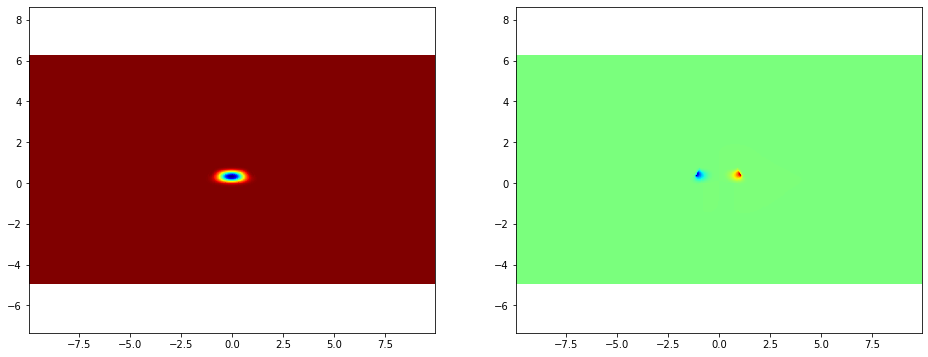

In [18]:
integrand = P2w.dot(E2w)
plt.rcParams['figure.figsize'] = [16, 6]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.pcolormesh(Z*1e6, X*1e6, np.real(integrand), cmap=cm.jet)
ax2.pcolormesh(Z*1e6, X*1e6, np.imag(integrand), cmap=cm.jet)
ax1.axis('equal')
ax2.axis('equal')

In [22]:
X2w = simps(simps(integrand, x), z)
X2w

(-1.9550769653688006e-34+1.663143501585592e-49j)

In [23]:
N2w

1.4353808923644616e-15

In [20]:
N2w = M1.N()
np.abs(X2w)*(2*pi*300*THz)/(4*N2w)

6.418563321009121e-05

Order of magnitude check

In [21]:
chi2 = 2*20*pm
k = (2*pi*300*THz)*chi2/(4*2*c)
print(k)

3.143767532927522e-05
